In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

### Create network of communications

In [2]:
path = 'Sender-receiver-weight.csv'
sendReceiverdf = pd.read_csv(path)

In [3]:
sendReceiverdf

,Sender,Receiver,Weight
0,Richard Shapiro,Leslie Lawner,2
1,Richard Shapiro,Sandra McCubbin,2
2,Richard Shapiro,Jeff Dasovich,97
3,Richard Shapiro,Linda Robertson,7
4,Richard Shapiro,Paul Kaufman,7
...,...,...,...
4503,Benjamin Rogers,Randall Martin,4
4504,Benjamin Rogers,Michelle Kelso,2
4505,Kerri Thompson,Kate Symes,684
4506,Kerri Thompson,Carla Hoffman,15


In [4]:
import networkx as nx

G_comm = nx.DiGraph()


for idx, row in sendReceiverdf.iterrows():
    G_comm.add_edge(row['Sender'], row['Receiver'], weight=row['Weight'])

In [5]:
G_comm

### Create the network of similarity of communications

In [6]:
path = 'sender-text.csv'
senderTextdf = pd.read_csv(path)
senderTextdf['All texts'] = senderTextdf['All texts'].astype(str)

In [7]:
senderTextdf

,Unnamed: 0,Sender,All texts
0,0,Kerri Thompson,think price deal ; missing deal jeff richter s...
1,1,Chris Germany,nan; De Man change spelling Druckett Dracut ow...
2,2,Evelyn Metoyer,Hi Kate Mike Swerzbin ref Prebon counterparty ...
3,3,Gerald Nemec,Attached form; Attached form; Article relevant...
4,4,Tana Jones,connection execution new ISDA Master Agreement...
5,5,Mark E Haedicke,efficiently EWS Mark Forwarded Mark E Haedick...
6,6,James D Steffes,Jeff helpful feedback prior starting deal fun...
7,7,John J Lavorato,Original Message From Guerriero Michael mailto...
8,8,Richard B Sanders,kidding Columbus day found PUC Jeff DasovichEN...
9,9,Richard Shapiro,Leslieafter seeing point writing extremely r...


In [8]:
# text in sender
text_list = senderTextdf['All texts'].tolist()
sender_list = senderTextdf['Sender'].tolist()

In [9]:
# Calculate the similarity between the abstracts using n-grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3))
X = vectorizer.fit_transform(text_list)
similarity_matrix = cosine_similarity(X, X)

In [10]:
# Create a graph from the similarity matrix
# Draw an edge between papers with similarity in the fourth quartile

# Calculate the 75th percentile of the similarity matrix
import numpy as np
percentile_75 = np.percentile(similarity_matrix, 75)
print(f"75th percentile = {percentile_75}")

G_sim = nx.Graph()
for i in range(similarity_matrix.shape[0]):
    for j in range(i+1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > percentile_75:
            G_sim.add_edge(sender_list[i], sender_list[j])

75th percentile = 0.44058040025146533


In [11]:
# Save the graph to a CSV file
nx.write_edgelist(G_sim, 'similarity_graph_emailDataset.csv', delimiter=',')

In [14]:
# Not sure what this list is for. We need to use the sender_list, because it contains the nodes in both graphs
# unique_elements = list(set(sendReceiverdf['Sender'].tolist() + sendReceiverdf['Receiver'].tolist()))
# node_list = list(unique_elements)
# len(node_list)

### Calculate the intersection for every node

In [12]:
# Iterate over all nodes and find the neighbors of each node in G_comm and G_sim
intersection_dict = {}
for node in sender_list:
    # Check if node is in both graphs
    # TODO: Figure out why some nodes are not in both graphs
    if node not in G_comm.nodes or node not in G_sim.nodes:
        print(f"Node '{node}' is not in both graphs")
        continue
    network_comm_neighbors = set(G_comm.neighbors(node))
    network_sim_neighbors = set(G_sim.neighbors(node))
    intersection = network_comm_neighbors.intersection(network_sim_neighbors)
    union = network_comm_neighbors.union(network_sim_neighbors)
    jaccard_similarity = len(intersection) / len(union)
    intersection_dict[node] = {
        'intersection': intersection,
        'union': union,
        'jaccard_similarity': jaccard_similarity
    }

# # Save the intersection dictionary to a JSON file
# with open('./data/intersection_dict.json', 'w') as f:
#     json.dump(intersection_dict, f, indent=4)

Node 'Benjamin Rogers' is not in both graphs
Node 'Carol St Clair' is not in both graphs


In [13]:
intersection_dict

{'Kerri Thompson': {'intersection': {'Kate Symes'},
  'union': {'Carla Hoffman', 'Evelyn Metoyer', 'Kate Symes'},
  'jaccard_similarity': 0.3333333333333333},
 'Chris Germany': {'intersection': set(),
  'union': {'Airam Arteaga',
   'Alex Perkins',
   'Alfonso Trabulsi',
   'Alicia Perkins',
   'Alvin Thompson',
   'Amy Ochoa',
   'Andrea Ring',
   'Angel Fuller',
   'Angie Zeman',
   'Anne Bertino',
   'Audrey Cook',
   'Barbara N Gray',
   'Beverly Beaty',
   'Bhavna Pandya',
   'Brad McKay',
   'Brandon Oliveira',
   'Brenda H Fletcher',
   'Briant Baker',
   'Bryce Baxter',
   'Cecilia Olvera',
   'Chad Gronvold',
   'Chris Germany',
   'Chris Meyer',
   'Chris Ordway',
   'Christopher Spears',
   'Cindy Vachuska',
   'Clayton Vernon',
   'Colin Tonks',
   'Colleen Sullivan',
   'Cora Pendergrass',
   'Crystal Hyde',
   'Cynthia Franklin',
   'Dan J Hyvl',
   'Dan Junek',
   'Dana Daigle',
   'Daren J Farmer',
   'Darla Saucier',
   'Dave Scott',
   'David Oliver',
   'David Wile',

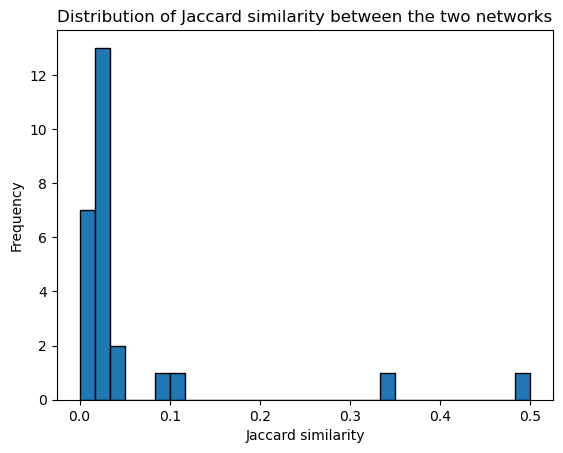

In [14]:
# Plot the distribution of the Jaccard similarity
jaccard_values = [value['jaccard_similarity'] for value in intersection_dict.values()]
fig, ax = plt.subplots()
ax.hist(jaccard_values, bins=30, edgecolor='black')
ax.set_xlabel('Jaccard similarity')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Jaccard similarity between the two networks')
plt.show()

### Visualise networks

In [15]:
from matplotlib import patches
def visualise_sender_networks(selected_sender):

    # Get the neighbors of the selected sender in the two networks
    comm_neighbors = list(G_comm.neighbors(selected_sender))
    sim_neighbors = list(G_sim.neighbors(selected_sender))

    # Get the intersection
    intersection = set(comm_neighbors).intersection(set(sim_neighbors))
    only_comm = set(comm_neighbors).difference(set(sim_neighbors))
    only_sim = set(sim_neighbors).difference(set(comm_neighbors))

    G_vis = nx.Graph()
    for neighbor in only_comm:
        G_vis.add_edge(selected_sender, neighbor, network='communication')
    for neighbor in only_sim:
        G_vis.add_edge(selected_sender, neighbor, network='similarity')
    for neighbor in intersection:
        G_vis.add_edge(selected_sender, neighbor, network='both')

    # Visualise the graph
    fig, ax = plt.subplots()
    pos = nx.spring_layout(G_vis)
    communication_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'communication']
    similarity_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'similarity']
    both_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'both']

    nx.draw_networkx_nodes(G_vis, pos, ax=ax, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G_vis, pos, edgelist=communication_edges, ax=ax, edge_color='red')
    nx.draw_networkx_edges(G_vis, pos, edgelist=similarity_edges, ax=ax, edge_color='blue')
    nx.draw_networkx_edges(G_vis, pos, edgelist=both_edges, ax=ax, edge_color='green')
    nx.draw_networkx_labels(G_vis, pos, ax=ax)

    ax.set_title(f'Neighbours of {selected_sender} in the two networks')

    # Add a legend for edges only
    communication_patch = patches.Patch(color='red', label='Communication')
    similarity_patch = patches.Patch(color='blue', label='Similarity')
    both_patch = patches.Patch(color='green', label='Both')
    ax.legend(handles=[communication_patch, similarity_patch, both_patch])

    ax.set_title(f'Neighbours of {selected_sender} in the two networks')
    
    plt.tight_layout()
    plt.show()

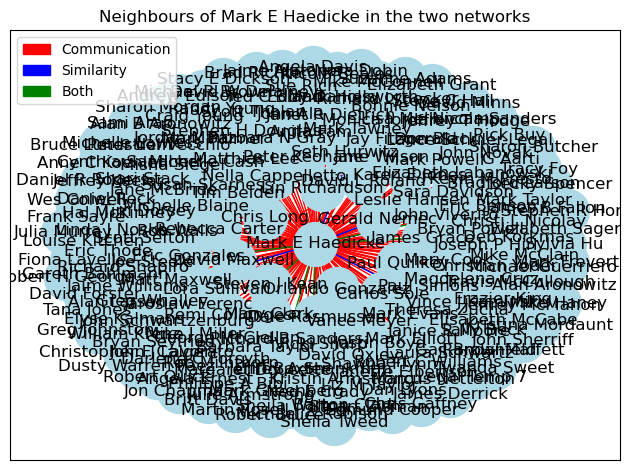

In [16]:
visualise_sender_networks('Mark E Haedicke')

# Convert intersection dict into intersection tuple and find the unique names

In [16]:
# List to store tuples of nodes with non-empty intersections
intersections = []

# Iterate through the dictionary
for node, data in intersection_dict.items():
    if data['intersection']:
        # For each item in the intersection, create a tuple with the current node
        for intersect_node in data['intersection']:
            intersections.append((node, intersect_node))
print(intersections)


[('Kerri Thompson', 'Kate Symes'), ('Evelyn Metoyer', 'Kate Symes'), ('Gerald Nemec', 'Mark Taylor'), ('Gerald Nemec', 'Dan J Hyvl'), ('Gerald Nemec', 'Tana Jones'), ('Gerald Nemec', 'Susan Scott'), ('Gerald Nemec', 'Richard B Sanders'), ('Tana Jones', 'Mark Taylor'), ('Tana Jones', 'Dan J Hyvl'), ('Tana Jones', 'Sara Shackleton'), ('Tana Jones', 'Steven J Kean'), ('Tana Jones', 'Richard B Sanders'), ('Tana Jones', 'Elizabeth Sager'), ('Tana Jones', 'Mark E Haedicke'), ('Mark E Haedicke', 'Mark Taylor'), ('Mark E Haedicke', 'Richard Shapiro'), ('Mark E Haedicke', 'Jeffrey A Shankman'), ('Mark E Haedicke', 'Steven J Kean'), ('Mark E Haedicke', 'Richard B Sanders'), ('Mark E Haedicke', 'Elizabeth Sager'), ('James D Steffes', 'Steven J Kean'), ('James D Steffes', 'Richard B Sanders'), ('James D Steffes', 'Jeff Dasovich'), ('James D Steffes', 'Richard Shapiro'), ('Richard B Sanders', 'James D Steffes'), ('Richard B Sanders', 'Mark Taylor'), ('Richard B Sanders', 'Tana Jones'), ('Richard B 

In [17]:
def find_unique_names(tuples):
 unique_names = set()
 for tuple in tuples:
   unique_names.update(tuple) 
 return list(unique_names)  
unique_names = find_unique_names(intersections)
print(unique_names)  

['Richard Shapiro', 'Jeffrey A Shankman', 'Kay Mann', 'Vince J Kaminski', 'Sally Beck', 'Elizabeth Sager', 'Dan J Hyvl', 'Sara Shackleton', 'Jeff Dasovich', 'Susan Scott', 'Steven J Kean', 'Richard B Sanders', 'Daren J Farmer', 'James D Steffes', 'Mark Taylor', 'Tana Jones', 'Maureen McVicker', 'Kerri Thompson', 'Mark E Haedicke', 'John J Lavorato', 'Kate Symes', 'Evelyn Metoyer', 'Shirley Crenshaw', 'Mike McConnell', 'Gerald Nemec']


# Counting lemma frequency

In [18]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords



In [19]:
def get_lemmas(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return set(lemmas)


In [20]:
# Collect lemmas from all rows for each sender
lemmas_by_sender = {}

# Iterate through the list of names
for name in unique_names:
    # Query DataFrame to find rows with matching sender name
    matched_rows = senderTextdf[senderTextdf['Sender'] == name]
    lemma_sets = []
    
    # Iterate through matched rows to collect lemma sets
    for _, row in matched_rows.iterrows():
        text = row['All texts']
        lemma_sets.append(get_lemmas(text))
    
    # Find common lemmas across rows for the sender
    common_lemmas = set.intersection(*lemma_sets)
    
    # Store common lemmas for the sender
    lemmas_by_sender[name] = common_lemmas


# All sender lemma 

In [21]:
sender_lemmas = lemmas_by_sender

# Collect all lemmas from all senders
all_lemmas = set()
for lemmas in sender_lemmas.values():
    all_lemmas.update(lemmas)

# Count the frequency of each lemma across all senders
lemma_frequency = {}
for lemma in all_lemmas:
    count = sum(lemma in lemmas for lemmas in sender_lemmas.values())
    lemma_frequency[lemma] = count

sorted_lemmas = sorted(lemma_frequency.items(), key=lambda x: x[1], reverse=True)

print("Most to least common lemmas for all senders in the intersection node:")
for lemma, frequency in sorted_lemmas:
    print(f"{lemma}: {frequency}")


Most to least common lemmas for all senders in the intersection node:
jeff: 25
told: 25
let: 25
following: 25
point: 25
k: 25
going: 25
minute: 25
chris: 25
end: 25
pas: 25
way: 25
thanks: 25
think: 25
week: 25
power: 25
price: 25
sure: 25
also: 25
said: 25
schedule: 25
th: 25
sorry: 25
ill: 25
heard: 25
help: 25
b: 25
month: 25
date: 25
info: 25
mark: 25
im: 25
talking: 25
thing: 25
detail: 25
interest: 25
good: 25
trying: 25
afternoon: 25
conference: 25
pm: 25
add: 25
talk: 25
time: 25
april: 25
cc: 25
fixed: 25
one: 25
wanted: 25
go: 25
c: 25
system: 25
number: 25
message: 25
today: 25
want: 25
find: 25
know: 25
asked: 25
morning: 25
ive: 25
look: 25
friday: 25
called: 25
like: 25
work: 25
thank: 25
energy: 25
need: 25
check: 25
service: 25
problem: 25
soon: 25
change: 25
june: 25
send: 25
say: 25
left: 25
phone: 25
yesterday: 25
received: 25
status: 25
great: 25
yes: 25
email: 25
right: 25
subject: 25
sent: 25
ask: 25
buy: 25
thought: 25
contact: 25
got: 25
mike: 25
ok: 25
day: 25


# Aggreate all sender leamma into a tuple

In [22]:
# Function to lemmatize a word
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)

lemmatized_word_freq = [(lemmatize_word(word), freq) for word, freq in sorted_lemmas]

# Apply sentiment analysis to all senders' leamma followed by visualisation

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mingshi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Positive Words: ['energy', 'thank', 'good', 'interest', 'number', 'want', 'like', 'help', 'ok', 'thanks', 'sure', 'great', 'yes', 'fyi', 'original', 'chance', 'hope', 'free', 'happy', 'fine', 'solution', 'best', 'important', 'resolved', 'clear', 'allow', 'better', 'well', 'support', 'agree', 'agreed', 'create', 'certain', 'opportunity', 'true', 'agreement', 'helpful', 'benefit', 'effective', 'please', 'ensure', 'kind', 'appreciate', 'ability', 'approved', 'fit', 'interested', 'credit', 'pretty', 'value', 'party', 'hopefully', 'grant', 'care', 'approval', 'created', 'love', 'ready', 'share', 'prepared', 'asset', 'play', 'legal', 'special', 'responsible', 'join', 'easier', 'natural', 'glad', 'attachment', 'reliant', 'increase', 'accept', 'okay', 'huge', 'interesting', 'apologize', 'wish', 'invite', 'save', 'strong', 'fun', 'reached', 'significant', 'positive', 'challenge', 'friend', 'giving', 'advantage', 'appreciated', 'recommend', 'commitment', 'holiday', 'resolve', 'accepted', 'clearl

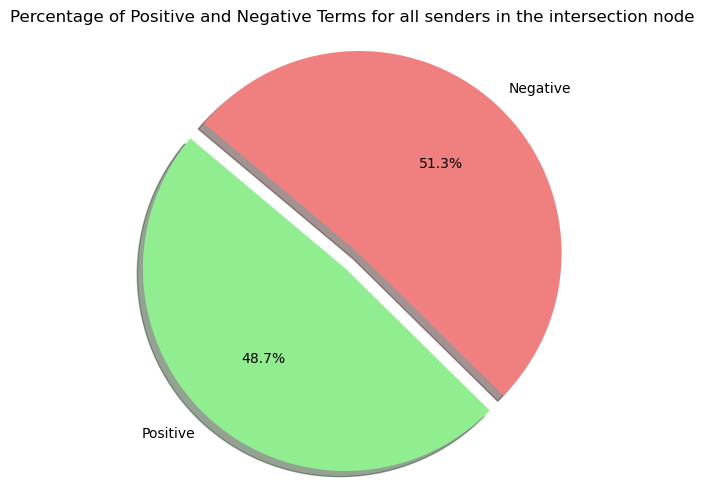

In [39]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

nltk.download('vader_lexicon')


word_freq =lemmatized_word_freq

sia = SentimentIntensityAnalyzer()


positive_words = []
negative_words = []
for word, _ in word_freq:
    sentiment_scores = sia.polarity_scores(word)
    if sentiment_scores['compound'] >= 0.05:
        positive_words.append(word)
    elif sentiment_scores['compound'] <= -0.05:
        negative_words.append(word)

total_count = sum(freq for _, freq in word_freq)
positive_percentage = (len(positive_words) / total_count) * 100
negative_percentage = (len(negative_words) / total_count) * 100


print("Positive Words:", positive_words)
print("Negative Words:", negative_words)

labels = ['Positive', 'Negative']
sizes = [positive_percentage, negative_percentage]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  
plt.title('Percentage of Positive and Negative Terms for all senders in the intersection node')

# Display the pie chart
plt.show()


# Individual node sentimental analysis

In [23]:
# Collect lemmas from all rows for each sender
lemmas_by_sender = {}

# Iterate through the list of names
for name in unique_names:
    print(name)
    # Query DataFrame to find rows with matching sender name
    matched_rows = senderTextdf[senderTextdf['Sender'] == name]
    lemma_sets = []
    
    # Iterate through matched rows to collect lemma sets
    for _, row in matched_rows.iterrows():
        text = row['All texts']
        lemma_sets.append(get_lemmas(text))
    # Store common lemmas for the sender
    lemmas_by_sender[name] = common_lemmas


Richard Shapiro
Jeffrey A Shankman
Kay Mann
Vince J Kaminski
Sally Beck
Elizabeth Sager
Dan J Hyvl
Sara Shackleton
Jeff Dasovich
Susan Scott
Steven J Kean
Richard B Sanders
Daren J Farmer
James D Steffes
Mark Taylor
Tana Jones
Maureen McVicker
Kerri Thompson
Mark E Haedicke
John J Lavorato
Kate Symes
Evelyn Metoyer
Shirley Crenshaw
Mike McConnell
Gerald Nemec


In [33]:
import csv
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
def classify_attitude(lemmas):
    positive_count = 0
    negative_count = 0
    
    # Count the number of positive and negative lemmas
    for lemma in lemmas:
        sentiment_scores = sia.polarity_scores(lemma)
        if sentiment_scores['compound'] >= 0.05:
            positive_count += 1
        elif sentiment_scores['compound'] <= -0.05:
            negative_count += 1
    
    # Determine the dominant attitude
    total_count = len(lemmas)
    positive_percentage = (positive_count / total_count) * 100
    if positive_percentage > 50:
        return 'positive'
    else:
        return 'negative'

In [34]:
# Dictionary to store sender names and their dominant attitudes
sender_attitudes = {}

# Classify the dominant attitude for each sender
for sender, lemmas in sender_lemmas.items():
    attitude = classify_attitude(lemmas)
    sender_attitudes[sender] = attitude

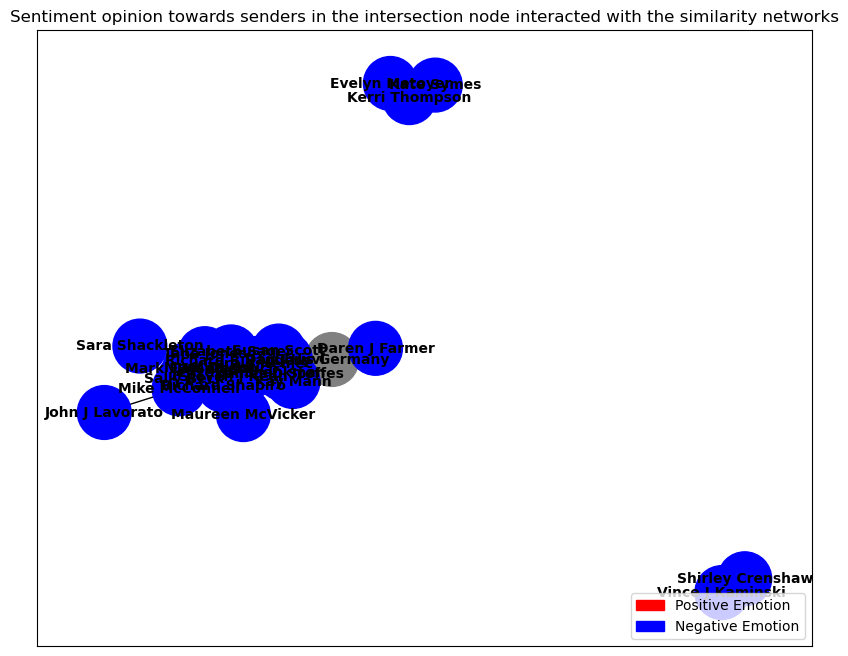

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming sender_attitudes and G_sim are defined elsewhere
sender_sentiment = sender_attitudes

# Define node colors based on sentiment
node_colors = {'positive': 'red', 'negative': 'blue'}

# Assign colors to nodes based on sentiment and check if node exists in the dictionary
node_color = []
for node in G_sim.nodes():
    if node in sender_sentiment:
        node_color.append(node_colors[sender_sentiment[node]])
    else:
        node_color.append('gray')  # Set color to gray for nodes not in the dictionary

# Draw the graph with the spring layout algorithm
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_sim, k=0.15)  # Adjust k to control the spacing between nodes
nx.draw_networkx(G_sim, pos=pos, with_labels=True, node_color=node_color, node_size=1500, font_size=10, font_weight='bold')

# Create color patches for the caption
red_patch = mpatches.Patch(color='red', label='Positive Emotion')
blue_patch = mpatches.Patch(color='blue', label='Negative Emotion')

# Add the color patches to the plot legend
plt.legend(handles=[red_patch, blue_patch], loc='lower right')

plt.title('Sentiment opinion towards senders in the intersection node interacted with the similarity networks')
plt.savefig("sentiment_similarity_network.png", format="PNG")  # Save the figure
plt.show()


# Communication network marked by sentimental polarity